# 演習
新たなデータ拡張を追加し、CNNのモデルを構築しましょう。  


## 領域のランダムな消去
新たにデータ拡張を追加します。  
transforms.RandomErasingにより、画像の領域がランダムに消去されます。   
https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomErasing


100%|██████████| 170498071/170498071 [00:02<00:00, 81053157.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000


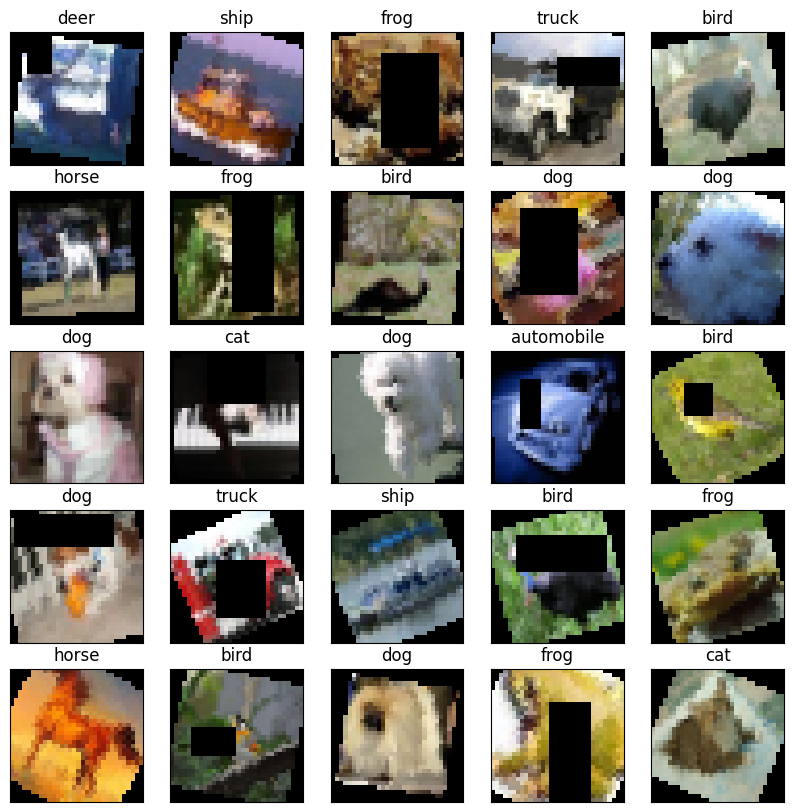

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
                                transforms.RandomAffine([-30, 30], scale=(0.8, 1.2)),  # 回転とリサイズ
                                transforms.ToTensor(),
                                transforms.RandomErasing(p=0.5)])  # 確率0.5でランダムに領域を消去
cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transform)
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = dataiter.__next__()  # 最初のバッチを取り出す

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
ここからCNNを実装していきます。  
以下のセルにコードを追記し、データ拡張の一環としてtransforms.RandomErasingによるランダムな画像領域の消去を実装しましょう。

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()
erase =transforms.RandomErasing(p=0.5)   # ← 左にコードを追記

transform_train = transforms.Compose([affine, flip, to_tensor, normalize, erase])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
以下のセルで、forwardメソッドの内部にコードを記述しCNNのモデルを構築しましょう。

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.fc1 = nn.Linear(32*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
       # ------- 以下にコードを書く -------
       x=self.pool(F.relu(self.conv1(x)))
       x=self.pool(F.relu(self.conv2(x)))
       x=x.view(-1,32*5*5)
       x=F.relu(self.fc1(x))
       x=self.dropout(x)
       x=self.fc2(x)
       return x
        # ------- ここまで -------

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
エラーが発生せず、学習に伴い訓練誤差とテスト誤差が共に減少することを確認しましょう。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [10]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).__next__()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8496787328549358 Loss_Test: 1.529707908630371
Epoch: 1 Loss_Train: 1.6405748328589418 Loss_Test: 1.4273266792297363
Epoch: 2 Loss_Train: 1.566770665328521 Loss_Test: 1.4414453506469727
Epoch: 3 Loss_Train: 1.5154556610700114 Loss_Test: 1.2929781675338745
Epoch: 4 Loss_Train: 1.4746432283040507 Loss_Test: 1.291756510734558
Epoch: 5 Loss_Train: 1.4433356191191222 Loss_Test: 1.2658807039260864
Epoch: 6 Loss_Train: 1.4213208537882247 Loss_Test: 1.2242180109024048
Epoch: 7 Loss_Train: 1.3948667793322707 Loss_Test: 1.1835713386535645
Epoch: 8 Loss_Train: 1.3828904959551818 Loss_Test: 1.1495431661605835
Epoch: 9 Loss_Train: 1.364632980750345 Loss_Test: 1.1429294347763062
Epoch: 10 Loss_Train: 1.3488636751613958 Loss_Test: 1.1219149827957153
Epoch: 11 Loss_Train: 1.337928790875408 Loss_Test: 1.125960111618042
Epoch: 12 Loss_Train: 1.3234043112953606 Loss_Test: 1.1024893522262573
Epoch: 13 Loss_Train: 1.3107837132938074 Loss_Test: 1.120697021484375
Epoch: 14 Loss_Train: 1

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

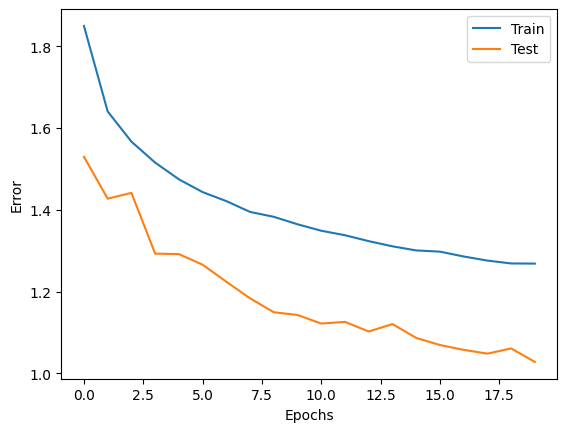

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [12]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 63.63999999999999%


## 訓練済みのモデルを使った予測
画像を入力し、モデルが機能していることを確かめます。

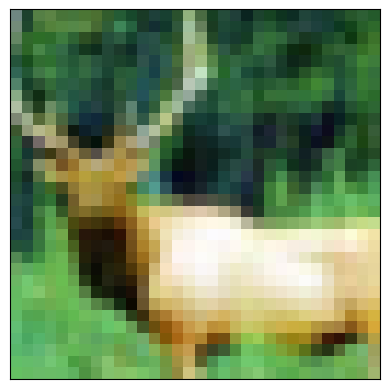

正解: deer 予測結果: deer


In [15]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.__next__()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])

# 解答例
以下は、どうしても手がかりがないときのみ参考にしましょう。

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()
erase = transforms.RandomErasing(p=0.5)  # ← 左にコードを追記

transform_train = transforms.Compose([affine, flip, to_tensor, normalize, erase])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.fc1 = nn.Linear(32*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # ------- 以下にコードを書く -------
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # ------- ここまで -------
        return x

net = Net()
net.cuda()  # GPU対応
print(net)